In [1]:
import pandas as pd 
from data_loading import load_tabular_data, preprocess_data
from NN import NN
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
from GenDataset import GenDataset
from DVGS import DVGS
from DVGS2 import DVGS2
from DVRL import DVRL
import time
import DShap
import copy
import torchmetrics
import networkx as nx

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [90]:
instinfo = pd.read_csv('../data/instinfo_beta.txt', low_memory=False, sep='\t')
instinfo.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_itime,pert_time_unit,cell_mfc_name,pert_mfc_id,...,sample_id,pert_type,cell_iname,qc_pass,dyn_range,inv_level_10,build_name,failure_mode,project_code,cmap_name
0,b11,NaN,20.00,uL,20 uL,72.0,72 h,h,VCAP,ERG_11,...,ERG013_VCAP_72H_X3_B11:O14,trt_sh,VCAP,0.0,4.20788,4220.5,NaN,dyn_range,ERG,ERG
1,b10,NaN,1.00,uL,1 uL,96.0,96 h,h,U2OS,TRCN0000072237,...,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:D10,ctl_vector,U2OS,0.0,4.73906,1462.0,NaN,inv_level_10,TAK,LACZ
2,b12,NaN,0.10,ng/ml,0.1 ng/ml,2.0,2 h,h,HEPG2,SOD3,...,CYT001_HEPG2_2H_X2_B12:N12,trt_lig,HEPG2,1.0,6.79642,3038.0,NaN,NaN,CYT,SOD3
3,b12,NaN,150.00,ng,150 ng,48.0,48 h,h,HEK293T,ENTRY00543,...,HSF038_HEK293T_48H_X2_B12:M01,trt_oe,HEK293T,0.0,23.79710,1642.0,NaN,inv_level_10,HSF,PDGFRA
4,f3b5,6.66,5.33,uM,6.66 uM,24.0,24 h,h,A375,BRD-K79781870,...,DOS043_A375_24H_X1_F3B5_DUO52HI53LO:D17,trt_cp,A375,0.0,6.78867,1558.0,NaN,"inv_level_10,qc_iqr",DOS,BRD-K79781870


In [91]:
instinfo.columns

Index(['bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit',
       'pert_idose', 'pert_time', 'pert_itime', 'pert_time_unit',
       'cell_mfc_name', 'pert_mfc_id', 'det_plate', 'det_well', 'rna_plate',
       'rna_well', 'count_mean', 'count_cv', 'qc_f_logp', 'qc_iqr', 'qc_slope',
       'pert_id', 'sample_id', 'pert_type', 'cell_iname', 'qc_pass',
       'dyn_range', 'inv_level_10', 'build_name', 'failure_mode',
       'project_code', 'cmap_name'],
      dtype='object')

In [98]:
instinfo.groupby('failure_mode')[['sample_id']].count().sort_values('sample_id').tail(10).index

Index(['count_mean', 'inv_level_10,qc_iqr', 'qc_f_logp',
       'inv_level_10,qc_iqr,dyn_range', 'qc_iqr,dyn_range', 'dyn_range',
       'qc_slope', 'inv_level_10', 'qc_iqr', 'count_cv'],
      dtype='object', name='failure_mode')

In [100]:
rAPC = pd.read_csv('../data/rAPC.csv')
rAPC.head()

,sample_id,rAPC,nrepl,L1,L2
0,TSAI001_AG062632_XH_X1_B16:G08,0.007033,3,0.788171,3.854645
1,TSAI001_AG062632_XH_X1_B16:E08,0.209657,3,0.783891,2.651862
2,TSAI001_AG062632_XH_X1_B16:F08,0.207303,3,0.891746,3.549395
3,TSAI001_AG062632_XH_X1_B16:F10,0.048069,3,0.773214,2.174079
4,TSAI001_AG062632_XH_X1_B16:G10,0.040723,3,0.836434,2.881478


In [101]:
rAPC = rAPC.merge(instinfo[['sample_id', 'failure_mode']], on='sample_id', how='left')[lambda x: x.failure_mode.isin(['count_mean', 'inv_level_10,qc_iqr', 'qc_f_logp',
       'inv_level_10,qc_iqr,dyn_range', 'qc_iqr,dyn_range', 'dyn_range',
       'qc_slope', 'inv_level_10', 'qc_iqr', 'count_cv'])]
rAPC.head()

,sample_id,rAPC,nrepl,L1,L2,failure_mode
1,TSAI001_AG062632_XH_X1_B16:E08,0.209657,3,0.783891,2.651862,inv_level_10
3,TSAI001_AG062632_XH_X1_B16:F10,0.048069,3,0.773214,2.174079,inv_level_10
36,TSAI001_APP11NPC1_XH_X1_B16:M08,0.026983,18,0.759296,1.917636,inv_level_10
41,TSAI001_SAD21NPC2_XH_X1_B16:C08,0.082345,18,2.253154,11.166529,qc_iqr
44,TSAI001_SAD21NPC2_XH_X1_B16:B08,0.086058,18,1.832453,7.543463,inv_level_10


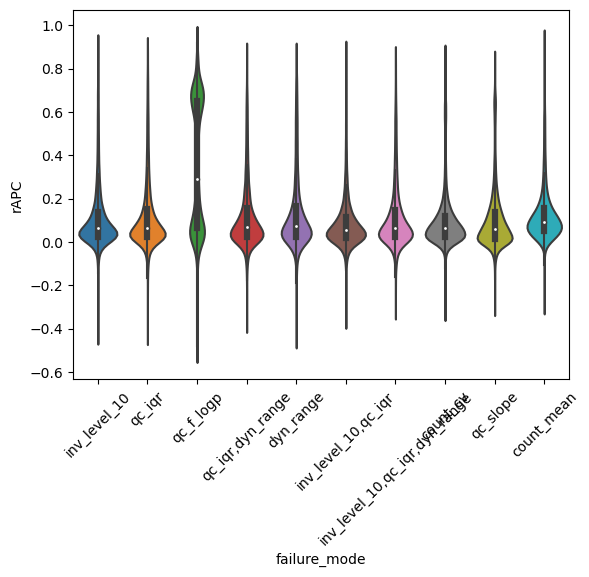

In [104]:
plt.figure()
sbn.violinplot(x='failure_mode', y='rAPC', data=rAPC)
plt.xticks(rotation = 45)
plt.show()

In [92]:
len(instinfo.failure_mode.unique())

array(['dyn_range', 'inv_level_10', nan, 'inv_level_10,qc_iqr',
       'inv_level_10,qc_iqr,dyn_range', 'count_mean,dyn_range',
       'qc_iqr,dyn_range', 'count_cv', 'qc_iqr',
       'qc_f_logp,qc_iqr,dyn_range', 'count_mean',
       'inv_level_10,qc_f_logp', 'count_cv,inv_level_10',
       'inv_level_10,qc_f_logp,qc_iqr,dyn_range', 'count_mean,count_cv',
       'qc_f_logp', 'count_cv,inv_level_10,qc_iqr,dyn_range',
       'qc_f_logp,qc_iqr', 'count_cv,qc_iqr,dyn_range',
       'qc_f_logp,dyn_range', 'inv_level_10,dyn_range',
       'count_cv,qc_f_logp,qc_iqr,dyn_range', 'qc_slope',
       'count_cv,dyn_range', 'count_cv,qc_f_logp,dyn_range',
       'count_mean,count_cv,qc_f_logp,dyn_range', 'count_mean,qc_f_logp',
       'count_mean,qc_iqr,dyn_range', 'count_cv,qc_iqr',
       'inv_level_10,qc_f_logp,dyn_range', 'count_mean,inv_level_10',
       'count_mean,inv_level_10,dyn_range',
       'count_mean,count_cv,inv_level_10,qc_iqr',
       'count_mean,count_cv,qc_f_logp,qc_iqr,dyn_rang

In [2]:
data_dir = '../data/temp/'

noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2, out=data_dir) # saves to disk
not_noise_idx = np.delete(np.arange(1000), noise_idx)
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv', data=data_dir)
train_dataset = GenDataset(x_train, y_train, return_index=True)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

In [3]:
#dict(model.named_parameters()).keys()

In [63]:
model = NN(in_channels=108, out_channels=1, num_layers=2, hidden_channels=100, norm=True, dropout=0., bias=True, act=torch.nn.Mish, out_fn=torch.nn.Sigmoid())
dvgs = DVGS2(train_dataset, valid_dataset, model)
print()

tic = time.time() 
A = dvgs.run(crit=torch.nn.BCELoss(), optim=torch.optim.Adam, lr=1e-3, num_epochs=100, batch_size=1000, num_workers=1, grad_params=None, verbose=True, use_cuda=True)
    
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')



using device: cuda
epoch 99 || avg loss: 0.09 || elapsed: 0 s/epoch
time elapsed: 0.41 min


In [64]:
t = torch.quantile(A.view(-1), q=0.95)

In [65]:
A2 = torch.triu(A, 1)
edge_index = (1.*(A2 > t)).nonzero().T

In [66]:
edge_weights = {}

for E in edge_index.detach().cpu().numpy().T: 
    E = tuple(E)
    if E in edge_weights: 
        edge_weights[E] += 1
    else: 
        edge_weights[E] = 1

res = {'node1':[], 'node2':[], 'weight':[]}
for (n1,n2),w in edge_weights.items(): 
    res['node1'].append(int(n1))
    res['node2'].append(int(n2))
    res['weight'].append(w)

res = pd.DataFrame(res)
res.head()


,node1,node2,weight
0,0,135,1
1,0,301,1
2,0,303,1
3,0,329,1
4,0,367,1


In [67]:
G = nx.Graph() 

for i in range(1000): 
    G.add_node(i)

for i,row in res.iterrows(): 
    #if row.weight > 25:
    #    G.add_edge(row.node1, row.node2, **{'weight':row.weight})
    G.add_edge(row.node1, row.node2, **{'weight':row.weight})

In [86]:
A3 = A.detach().cpu().numpy()
A3[np.abs(A3) < t.item()] = 0
G = nx.from_numpy_array(A.detach().cpu().numpy())
len(G)

1000

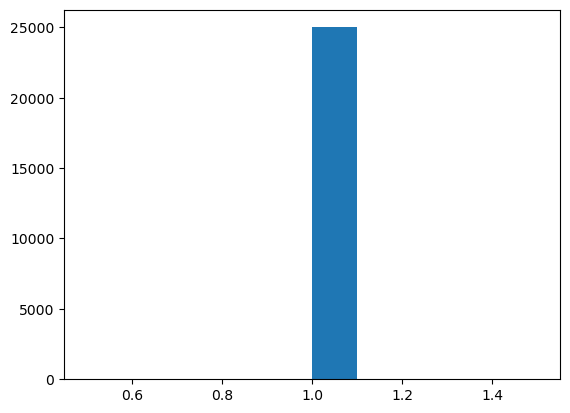

In [87]:
plt.figure()
plt.hist(res.weight)
plt.show()

In [88]:
pos = nx.spring_layout(G, k=0.5, weight='weight')

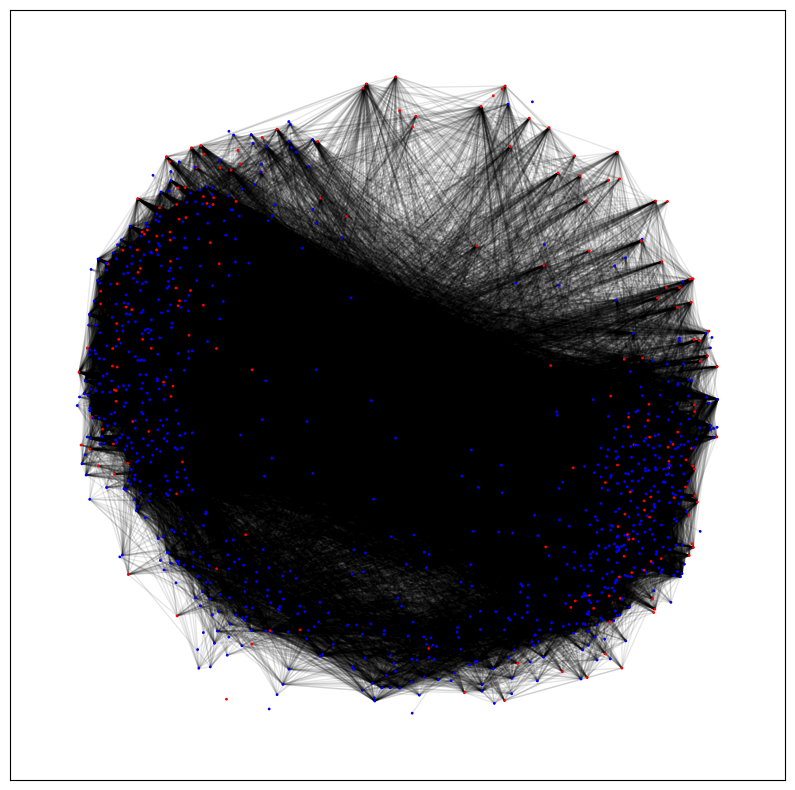

In [89]:
node_colors = np.array(['b']*1000)
node_colors[noise_idx] = 'r'
nodelist = np.arange(1000)

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, nodelist=nodelist, pos=pos, node_color=node_colors, node_size=1)
nx.draw_networkx_edges(G, pos=pos, alpha=0.1)
plt.show()

In [71]:
A

tensor([[  0.0000, -20.1499,  26.4069,  ...,  41.7790, -47.0060, -28.1694],
        [-20.1499,   0.0000, -66.1838,  ..., -25.4607,  42.7041,  78.0924],
        [ 26.4069, -66.1838,   0.0000,  ...,  33.8097, -43.0437, -72.2731],
        ...,
        [ 41.7790, -25.4607,  33.8097,  ...,   0.0000, -42.5241, -32.6652],
        [-47.0060,  42.7041, -43.0437,  ..., -42.5241,   0.0000,  50.9681],
        [-28.1694,  78.0924, -72.2731,  ..., -32.6652,  50.9681,   0.0000]])

In [61]:
pg = nx.pagerank(G)

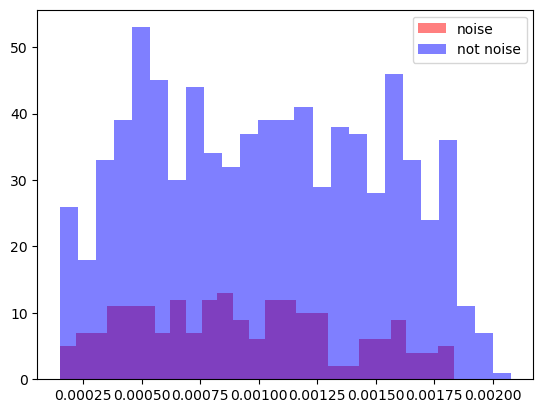

In [62]:
plt.figure()
plt.hist([pg[ii] for ii in noise_idx], bins=25, alpha=0.5, color='r', label='noise')
plt.hist([pg[ii] for ii in not_noise_idx], bins=25, alpha=0.5, color='b', label='not noise')
plt.legend()
plt.show()

In [64]:
pg[noise_idx].mean()

TypeError: unhashable type: 'numpy.ndarray'

In [62]:
np.array(pg.values())

array(dict_values([0.0008945581235547111, 0.0015245429821276984, 0.00143063271425427, 0.00026913612149679744, 0.0006674562916492068, 0.000883069562311659, 0.001275315624028646, 0.0013344306178258306, 0.0003485485697869605, 0.0014404378700710145, 0.0008583288084596644, 0.0013764455770722537, 0.0010477889364067738, 0.0012289705645444305, 0.0010225317354304602, 0.0008640015399472088, 0.0013033723642688485, 0.0007229339658249509, 0.0012130111781775514, 0.0007733792000421168, 0.00035231186998810283, 0.001326385911098371, 0.0014565830785599142, 0.0010782163607807004, 0.0004750641413202929, 0.0015055416710961663, 0.0012001176770930209, 0.0003476134133503974, 0.00037388831949795127, 0.0012168744696133085, 0.000991628656832868, 0.0003897464374173877, 0.0008471414051496355, 0.0014003524377040359, 0.0002631816869177068, 0.0016920557276090865, 0.001254474382574208, 0.0014496958848195932, 0.0011392537793838038, 0.000490332684659728, 0.0015507551740648524, 0.00027599812559670476, 0.00080553391380907


pretraining `ori_model` and `val_model` 
outer iteration: 499 || reward: -0.0290 || dvrl perf: 0.7873 || baseline: 0.8148 || log entropy beta: -4.1824 || epoch elapsed: 0.6 s s
time elapsed: 6.81 min


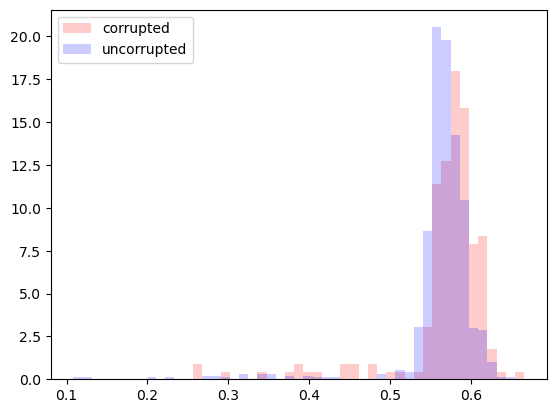

In [11]:
pred = NN(in_channels=108, out_channels=2, num_layers=2, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Softmax(dim=-1))
est = NN(in_channels=112, out_channels=1, num_layers=2, hidden_channels=300, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())
#est = NNest(in_channels=109, yhat_channels=2, out_channels=1, num_layers=4, hidden_channels=100, comb_channels=10, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())

dvrl = DVRL(train_dataset, valid_dataset, test_dataset, predictor=pred, estimator=est, problem='classification')
CEL = torch.nn.CrossEntropyLoss() 
#dvrl.predictor = dvrl.pretrain(model=dvrl.predictor, dataset=dvrl.train, crit=lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), epochs=100, lr=1e-3)
print()

tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'auroc', 
                     crit_pred              = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), 
                     outer_iter             = 500, 
                     inner_iter             = 100, 
                     outer_batch            = 2000, 
                     outer_workers          = 1, 
                     inner_batch            = 256, 
                     estim_lr               = 1e-2, 
                     pred_lr                = 1e-3, 
                     moving_average_window  = 20,
                     entropy_beta           = 0.01, 
                     entropy_decay          = 0.99,
                     fix_baseline           = False)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')                     

plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[noise_idx, 0].detach().cpu().numpy().ravel(), color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[not_noise_idx, 0].detach().cpu().numpy().ravel(), color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

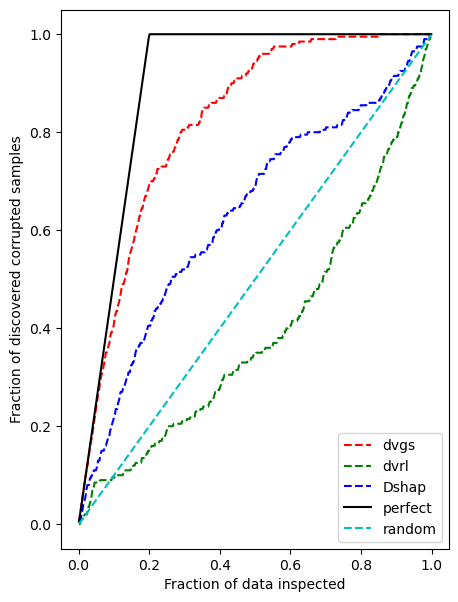

In [12]:
ks = np.linspace(1,999,500)
n_dvgs = []
n_shap = []
n_dvrl = []
n_perfect = [] 
n_random = [] 


for k in ks: 
    idx_dvgs = np.argsort(vals_dvgs.mean(axis=1).ravel()            )[:int(k)]
    idx_dvrl = np.argsort(vals_dvrl.detach().cpu().numpy().ravel()  )[:int(k)]
    idx_shap = np.argsort(vals_shap.ravel()                         )[:int(k)]

    n_dvgs.append( len(set(noise_idx).intersection(set(idx_dvgs)))/200 ) 
    n_dvrl.append( len(set(noise_idx).intersection(set(idx_dvrl)))/200 ) 
    n_shap.append( len(set(noise_idx).intersection(set(idx_shap)))/200 ) 
    n_perfect.append(min(int(k), 200)/200)
    n_random.append(k*0.2/200)

plt.figure(figsize=(5, 7))
plt.plot(ks/1000, n_dvgs, 'r--', label='dvgs')
plt.plot(ks/1000, n_dvrl, 'g--', label='dvrl')
plt.plot(ks/1000, n_shap, 'b--', label='Dshap')
plt.plot(ks/1000, n_perfect, 'k-', label='perfect')
plt.plot(ks/1000, n_random, 'c--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.show()

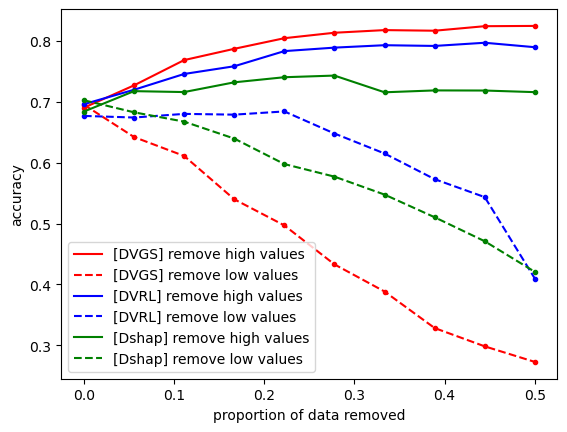

In [113]:
def train_model(x_train, y_train, x_test, y_test, epochs=200): 

    model = NN(in_channels=108, out_channels=1, num_layers=2, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters())

    for epoch in range(epochs): 

        optim.zero_grad()
        yhat_train = model(x_train).squeeze()
        loss = crit(yhat_train, y_train)
        loss.backward()
        optim.step()

    yhat_test = 1. * (model(x_test).detach().numpy() > 0.5).ravel()
    y_test = y_test.detach().numpy().ravel()

    acc = (yhat_test == y_test).sum() / y_test.shape[0]

    return acc

### 

def get_perf_curve(dvs, ks, epochs=500): 
    acc_low = []
    acc_high = []
    for k in ks: 
        print(int(k), end='\r')
        sorted_idx = np.argsort(dvs)

        high_idxs = sorted_idx[0:(1000-int(k))]
        low_idxs = sorted_idx[(int(k)):]

        acc_low.append(train_model(torch.tensor(x_train[high_idxs, :], dtype=torch.float32), torch.tensor(y_train[high_idxs], dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), epochs=epochs))
        acc_high.append(train_model(torch.tensor(x_train[low_idxs, :], dtype=torch.float32), torch.tensor(y_train[low_idxs], dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), epochs=epochs))

    return acc_low, acc_high

ks = np.linspace(0,500,10)
dvgs_low, dvgs_high = get_perf_curve(vals_dvgs.mean(axis=1), ks)
dvrl_low, dvrl_high = get_perf_curve(vals_dvrl.detach().cpu().numpy().ravel(), ks)
shap_low, shap_high = get_perf_curve(vals_shap, ks)



plt.figure()
plt.plot(ks/1000, dvgs_high, 'r-', label='[DVGS] remove high values')
plt.plot(ks/1000, dvgs_high, 'r.',)
plt.plot(ks/1000, dvgs_low, 'r--', label='[DVGS] remove low values')
plt.plot(ks/1000, dvgs_low, 'r.')

plt.plot(ks/1000, dvrl_high, 'b-', label='[DVRL] remove high values')
plt.plot(ks/1000, dvrl_high, 'b.',)
plt.plot(ks/1000, dvrl_low, 'b--', label='[DVRL] remove low values')
plt.plot(ks/1000, dvrl_low, 'b.')

plt.plot(ks/1000, shap_high, 'g-', label='[Dshap] remove high values')
plt.plot(ks/1000, shap_high, 'g.',)
plt.plot(ks/1000, shap_low, 'g--', label='[Dshap] remove low values')
plt.plot(ks/1000, shap_low, 'g.')

plt.legend()
plt.xlabel('proportion of data removed')
plt.ylabel('accuracy')
plt.show()

In [ ]:
dist = torch.distributions.Bernoulli(torch.tensor([0.1, 0.3, 0., 0.99]))

In [ ]:
dist.sample()

tensor([0., 0., 0., 1.])

In [ ]:
sim_vals1 = sim_vals

In [ ]:
c = np.zeros((1000))
c[noise_idx] = 1
res = pd.DataFrame({'dv1':sim_vals.mean(axis=1), 'dv2':sim_vals1.mean(axis=1), 'corrupted':c})
#res.head()
res.corr('spearman')

NameError: name 'sim_vals1' is not defined

In [ ]:
plt.figure()
sbn.scatterplot(x='dv1', y='dv2', hue='corrupted', data=res)
plt.show()

NameError: name 'res' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
sim_vals = vals_dvgs

In [ ]:
c_true = np.ones(1000, dtype=float)
c_true[noise_idx] = 0.
aucs = []
for i in range(sim_vals.shape[1]): 
    x = sim_vals[:, i]
    z = (x - min(x))/(max(x) - min(x))
    aucs.append( roc_auc_score(c_true, z) )

    

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

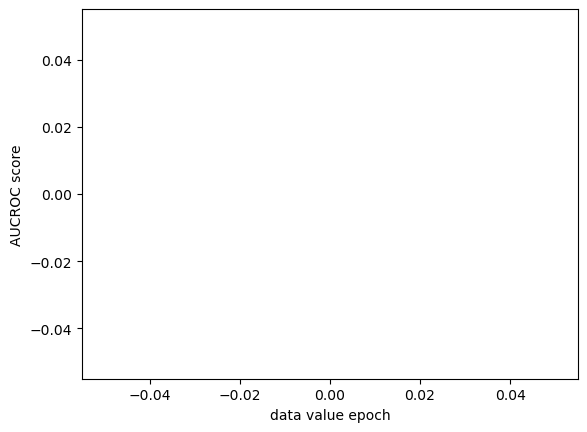

In [ ]:
plt.figure()
plt.plot(aucs)
plt.xlabel('data value epoch')
plt.ylabel('AUCROC score')
plt.show()

In [ ]:
not_noise_idx = np.delete(np.arange(1000), noise_idx)

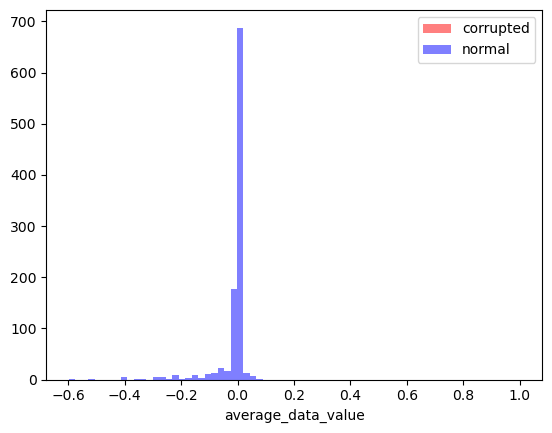

In [ ]:
plt.figure()
plt.hist(sim_vals.mean(axis=1)[noise_idx], color='r', label='corrupted', alpha=0.5, bins=30)
plt.hist(sim_vals.mean(axis=1)[not_noise_idx], color='b', label='normal', alpha=0.5, bins=30)
plt.xlabel('average_data_value')
plt.legend()
plt.show()

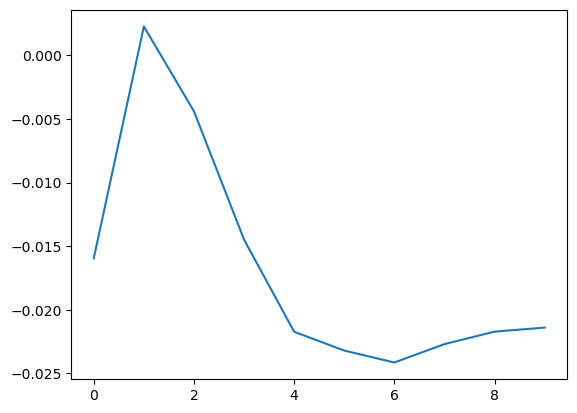

In [ ]:
plt.figure()
plt.plot(sim_vals.mean(axis=0))
plt.show()

/tmp/ipykernel_3791/2330010559.py:6: RuntimeWarning: Mean of empty slice.
  plt.plot(sim_vals[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
/home/teddy/miniconda3/envs/dvrl/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


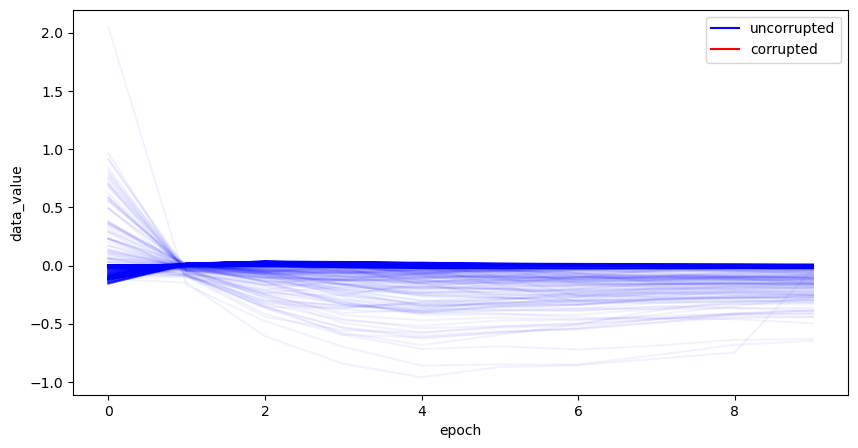

In [ ]:
sim_vals = vals_dvgs
plt.figure(figsize=(10,5))
plt.plot(sim_vals[noise_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals[not_noise_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals[not_noise_idx, :].T.mean(axis=1), color='b', alpha=1., label='uncorrupted')
plt.plot(sim_vals[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.legend()
plt.show()

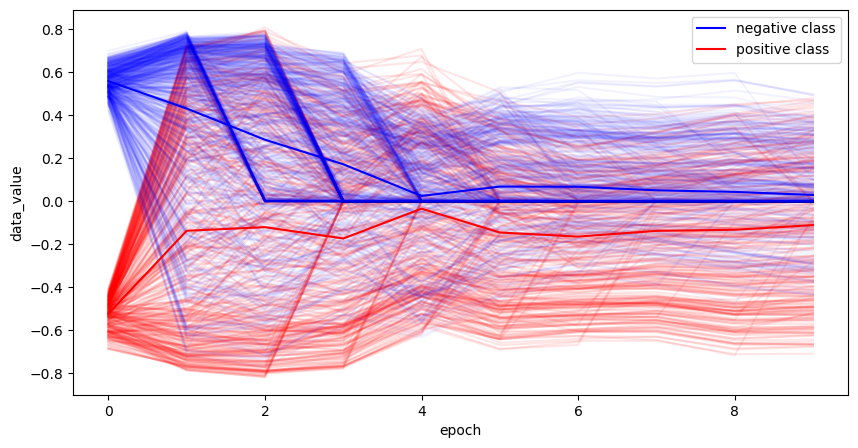

In [ ]:
pos_idx = y_train.nonzero()[0].ravel()
neg_idx = np.delete(np.arange(1000), pos_idx)

plt.figure(figsize=(10,5))
plt.plot(sim_vals[pos_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals[neg_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals[neg_idx, :].T.mean(axis=1), color='b', alpha=1., label='negative class')
plt.plot(sim_vals[pos_idx, :].T.mean(axis=1), color='r', alpha=1., label='positive class')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.legend()
plt.show()

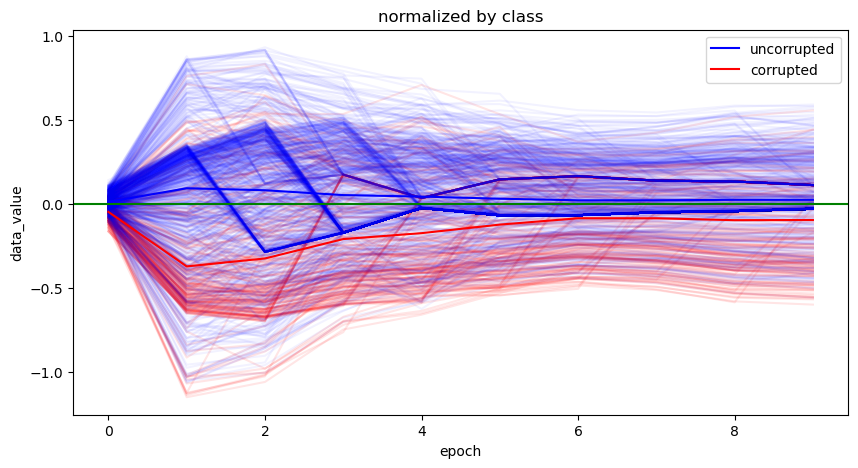

In [ ]:
pos_avg_sim = sim_vals[pos_idx, :].mean(axis=0)
neg_avg_sim = sim_vals[neg_idx, :].mean(axis=0)

sim_vals2 = sim_vals.copy()
sim_vals2[pos_idx, :] -= pos_avg_sim.reshape(-1,1).T
sim_vals2[neg_idx, :] -= neg_avg_sim.reshape(-1,1).T

plt.figure(figsize=(10,5))
plt.plot(sim_vals2[noise_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals2[not_noise_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals2[not_noise_idx, :].T.mean(axis=1), color='b', alpha=1., label='uncorrupted')
plt.plot(sim_vals2[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.title('normalized by class')
plt.legend()
plt.axhline(0, color='g')
plt.show()

In [ ]:

ks = np.linspace(1,500,500)
n_corrupt = []
n_perfect = [] 
n_random = [] 

dvs = sim_vals.mean(axis=1)
for k in ks: 
    idx = np.argpartition(dvs, int(k))[:int(k)]
    n_corrupt.append( len(set(noise_idx).intersection(set(idx)))/200 ) 
    n_perfect.append(min(int(k), 200)/200)
    n_random.append(k*0.2/200)

plt.figure(figsize=(5, 7))
plt.plot(ks/1000, n_corrupt, 'r--', label='dvgs')
plt.plot(ks/1000, n_perfect, 'k-', label='perfect')
plt.plot(ks/1000, n_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.show()

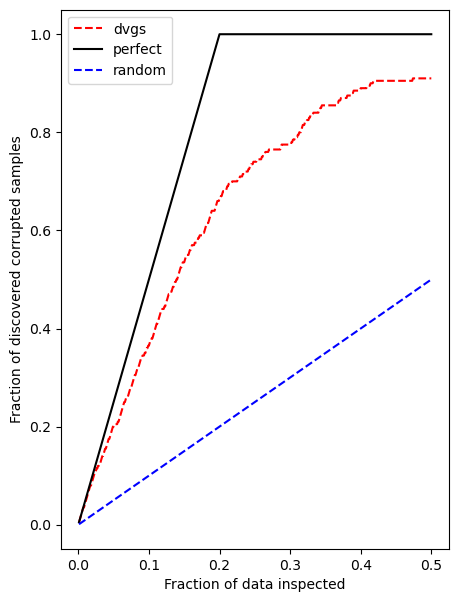

In [ ]:
plt.figure(figsize=(5, 7))
plt.plot(ks/1000, n_corrupt, 'r--', label='dvgs')
plt.plot(ks/1000, n_perfect, 'k-', label='perfect')
plt.plot(ks/1000, n_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.show()

In [ ]:
def train_model(x_train, y_train, x_test, y_test, epochs=200): 

    model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0.1, bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid)

    crit = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters())

    for epoch in range(epochs): 

        optim.zero_grad()
        yhat_train = model(x_train).squeeze()
        loss = crit(yhat_train, y_train)
        loss.backward()
        optim.step()

    yhat_test = 1. * (model(x_test).detach().numpy() > 0.5).ravel()
    y_test = y_test.detach().numpy().ravel()

    acc = (yhat_test == y_test).sum() / y_test.shape[0]

    return acc

In [ ]:
ks = np.linspace(0,500,25)
dvs = sim_vals.mean(axis=1)
high_accs = []
low_accs = []

for k in ks: 
    print(int(k), end='\r')
    sorted_idx = np.argsort(dvs)

    high_idxs = sorted_idx[0:(1000-int(k))]
    low_idxs = sorted_idx[(int(k)):]


    high_accs.append(train_model(x_train[high_idxs, :], y_train[high_idxs], x_test, y_test, epochs=500))
    low_accs.append(train_model(x_train[low_idxs, :], y_train[low_idxs], x_test, y_test, epochs=500))


plt.figure()
plt.plot(ks/1000, high_accs, 'r-', label='remove high values')
plt.plot(ks/1000, high_accs, 'r.',)
plt.plot(ks/1000, low_accs, 'b-', label='remove low values')
plt.plot(ks/1000, low_accs, 'b.')
plt.legend()
plt.xlabel('proportion of data removed')
plt.ylabel('accuracy')
plt.show()

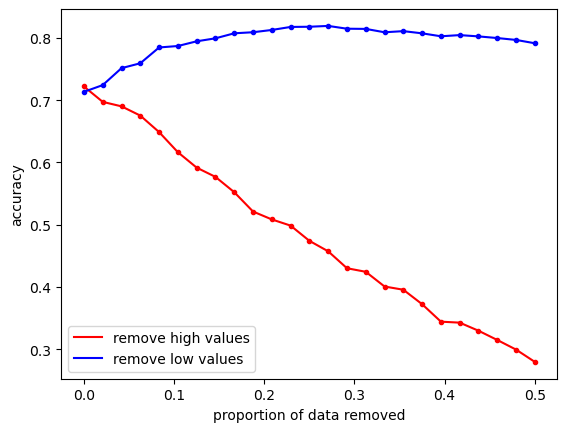

In [ ]:
plt.figure()
plt.plot(ks/1000, high_accs, 'r-', label='remove high values')
plt.plot(ks/1000, high_accs, 'r.',)
plt.plot(ks/1000, low_accs, 'b-', label='remove low values')
plt.plot(ks/1000, low_accs, 'b.')
plt.legend()
plt.xlabel('proportion of data removed')
plt.ylabel('accuracy')
plt.show()